# Test root mean square delay spread (RMS DS) map

Testing is done by:
- Consering a small and single-cell map computed by the evaluated tracer
- Placing a Sionna receiver in the center of the map

The RMS-DS computed by the evaluated tracer should match the one computed from the channel impulse response (CIR) computed by Sionna for the receiver located at the center of the map.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import pickle

from sionna.rt import Scene, Transmitter, PlanarArray, Receiver
from instant_rm import MapTracer

In [3]:
# Test configuration

scene_file = "../scenes/box/box.xml"

tx_position = np.array([1.0, 0.0, 4.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

cm_center = np.array([0.0, 0.0, 1.0])
cm_orientation = np.array([0., 0., 0.])
cm_size = np.array([0.05, 0.05]) # Small CM with a single cell
cm_cell_size = cm_size

# Testing is done for multiple values of the maximum depth
max_depths = [1,2,3,4,5,6,7,8,9,10]

# Number of samples used to generate the reference RMS-DS with
# Sionna
num_samples_ref = int(1e6)

# Number of samples used for the evaluated tracer
num_samples_eval = int(1e9)

In [4]:
# Utility to compute the RMS-DS from a CIR
def compute_rms_ds(a, tau):
    
    # Total power
    p = np.sum(a, axis=-1, keepdims=True)
    
    # RMS delay spread
    tau_bar = np.sum(a*tau, axis=-1, keepdims=True)/p
    rms_ds = np.sqrt(np.sum(a*np.square(tau - tau_bar), axis=-1, keepdims=True)/p)

    rms_ds = np.squeeze(rms_ds, axis=-1)
    
    return rms_ds

In [5]:
# Sionna is used to generate reference RMS-DS

sn_scene = Scene(scene_file)
sn_scene.frequency = fc

# Configure antenna array for all transmitters
sn_scene.tx_array = PlanarArray(num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern=tx_pattern,
                                polarization="V",
                                polarization_model=2)

# Configure antenna array for all receivers
sn_scene.rx_array = PlanarArray(num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="iso",
                                polarization="VH",
                                polarization_model=2)
# Add a transmitters
tx = Transmitter(name="tx",
                 position=tx_position,
                 orientation=tx_orientation)
sn_scene.add(tx)

rx = Receiver(name=f"rx-",
                 position=cm_center,
                 orientation=[0.0,0.0,0.0])
sn_scene.add(rx)

In [6]:
# Load Mitsuba scene
mi_scene = mi.load_file(scene_file)

In [7]:
vals_rms_ds = []
vals_rms_ds_ref = []
for max_depth in max_depths:

    ## Reference with Sionna
    
    # Compute CIR
    paths = sn_scene.compute_paths(max_depth=max_depth, num_samples=num_samples_ref,
                                   check_scene=False, los=True, diffraction=False, scattering=False)
    a = paths.a.numpy()[0,:,:,0,0,:,0]
    # [num_rx, num_paths]
    a = np.sum(np.square(np.abs(a)), axis=1)
    tau = paths.tau.numpy()[0,:,0]*1e9
    
    # Compute reference RMS-DS
    rms_ds_ref = compute_rms_ds(a,tau)
    vals_rms_ds_ref.append(rms_ds_ref)

    ## Value from the traced RMS-DS map

    tracer = MapTracer(mi_scene, fc,
                       tx_pattern, tx_slant_angle,
                       cm_center, cm_orientation, cm_size, cm_cell_size,
                       num_samples_eval, max_depth)
    
    # Trace the RMS-DS map
    _, rdsm,_,_ = tracer(tx_position, tx_orientation)
    rms_ds = rdsm.numpy()[0,0]
    vals_rms_ds.append(rms_ds)

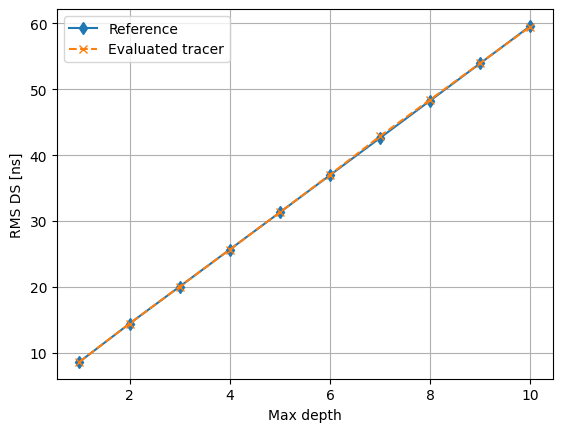

In [8]:
plt.figure()
plt.plot(max_depths, vals_rms_ds_ref, 'd-', label="Reference")
plt.plot(max_depths, vals_rms_ds, 'x--', label="Evaluated tracer")
plt.xlabel("Max depth")
plt.ylabel("RMS DS [ns]")
plt.grid(True)
plt.legend()